# Imports

In [2]:
import numpy as np
from numpy.random import randint
import numpy as np
import torch
import gym
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

SEED = 42
np.random.seed(SEED)

# Environment

## Map Generation

In [3]:
def generate_environment(
    min_world_size=3,
    max_worls_size=10,
    min_desirable_area_size=1,
    max_desirable_area_size=2,
    min_number_objects=1,
    max_number_objects=9
) -> np.ndarray:
    '''Creates map with desirable are in given range that the do not contradict.
    '''

    rows_env, cols_env = randint(min_world_size, max_worls_size + 1, size=2)
    environment = np.zeros((rows_env, cols_env), dtype=int)

    rows_des, cols_des = randint(min_desirable_area_size, max_desirable_area_size + 1, size=2)
    rows_des, cols_des = min(rows_des, rows_env - 1), min(cols_des, cols_env - 1)

    row_corner_des = randint(rows_env - rows_des + 1)
    col_corner_des = randint(cols_env - cols_des + 1)

    environment[
        row_corner_des : row_corner_des + rows_des, \
        col_corner_des : col_corner_des + cols_des
    ] = - np.ones((rows_des, cols_des), dtype=int)


    return environment

generate_environment(max_worls_size=4, max_desirable_area_size=3)

array([[ 0,  0,  0,  0],
       [ 0,  0,  0,  0],
       [ 0, -1, -1, -1]])

## Read Map

In [4]:
def read_map(filename):
    map = []

    with open(filename) as file:
        text = file.read()
    lines = text.splitlines()

    for line in lines:
        line = [cell for cell in line.split()]
        map.append(line)

    return np.array(map)

In [5]:
map = read_map('./environments/1.txt')
map

array([['0', '0', '0', '0', '2'],
       ['r', 'r', 'r', '0', '2'],
       ['r', 'r', 'r', '0', '2'],
       ['r', 'r', 'r', '0', '0'],
       ['0', '0', '0', '0', '0'],
       ['0', '0', '1', '1', '0']], dtype='<U1')

## Representation

In [6]:
class Cargo:
    '''Represents Cargo on the map.

    Cargo is stored as list of tuples (row, column).
    Upper left corner piece has coordinates (0, 0) and all the other parts are represented
    by the shift from this conener. Real position of left upper corner is stored.

    Args:
        map: World map represented as matrix of chars.
        index: Digit that represents cargo on the map.

    Attributes:
        shape (list): List of tupples which represents cargo's parts coordinates.
    '''

    def __init__(self, map, index: str) -> None:
        self.map = map
        self.index = index
        self.shape = self.get_cargo_shape()
        self.devide_into_parts()

    
    def get_upper_left_corner(self, cargo):
        '''Finds coordinates of upper left corner.
        If there is no corner returns coordinates of bounding
        box's corner.
        '''
        upper = 1e9
        left = 1e9

        lower = 0
        right = 0

        for row, col in cargo:
            upper = min(upper, row)
            left = min(left, col)

            lower = max(lower, row)
            right = max(right, col)

        self.lower_shift = lower - upper
        self.right_shift = right - left
        
        return upper, left


    def get_cargo_shape(self):
        '''Returns list of tupples with shift of cargo's cells
        with respect to right lower corner (if it even does not exist).
        '''
        cargo = []

        for row in range(len(self.map)):
            for col in range(len(self.map[0])):
                if self.map[row][col] == self.index:
                    cargo.append((row, col))

        corner_row, corner_col = self.get_upper_left_corner(cargo)
        self.position = (corner_row, corner_col)
        self.lower_right = (corner_row + self.lower_shift, corner_col + self.right_shift)

        for part_idx in range(len(cargo)):
            row, col = cargo[part_idx]
            cargo[part_idx] = (row - corner_row, col - corner_col)
        
        return cargo

    
    def devide_into_parts(self):
        '''Finds pieces of cargo which belong to left, right,
        upper and lower parts.
        '''
        hight = self.lower_shift + 1
        width = self.right_shift + 1

        self.upper_part = []
        self.lower_part = []
        self.left_part = []
        self.right_part = []

        for row, col in self.shape:
            if hight % 2 == 0:
                if row < (hight / 2):
                    self.upper_part.append((row, col))
                elif row >= (hight / 2):
                    self.lower_part.append((row, col))
            else:
                if row < (hight / 2 - 1):
                    self.upper_part.append((row, col))
                elif row > (hight / 2):
                    self.lower_part.append((row, col))
            
            if width % 2 == 0:
                if col < (width / 2):
                    self.left_part.append((row, col))
                elif col >= (width / 2):
                    self.right_part.append((row, col))
            else:
                if col < (width / 2 - 1):
                    self.left_part.append((row, col))
                elif col > (width / 2):
                    self.right_part.append((row, col))
            

    def get_cargo_coordinates(self, corner_row:int, corner_col:int):
        '''Returns coordinates of cargo given position of left upper corner.
        '''
        cargo_coordinates = []

        for row_shift, col_shift in self.shape:
            cargo_coordinates.append((corner_row + row_shift, corner_col + col_shift))

        return cargo_coordinates

    
    def is_valid_position(self, corner_row, corner_col):
        '''Returns whether the cargo can be placed at given position.
        '''

        cargo_coordinates = self.get_cargo_coordinates(corner_row, corner_col)

        def is_valid_cell(row, col):
            n_rows = len(self.map)
            n_cols = len(self.map[0])

            if row < 0:
                return False
            if row >= n_rows:
                return False
            if col < 0:
                return False
            if col >= n_cols:
                return False

            return True

        check = [is_valid_cell(row, col) for row, col in cargo_coordinates]
        is_valid = all(check)

        return is_valid

    
    def set_position(self, corner_row, corner_col):
        '''Sets new position for cargo if it valid.
        '''
        if self.is_valid_position(corner_row, corner_col):
            self.position = (corner_row, corner_col)
            self.lower_right = (corner_row + self.lower_shift, corner_col + self.right_shift)


    def move(self, direction):
        '''Shifts cargo in given direction by one cell if it leads to the valid
        postion.
        '''
        if direction == 'U':
            self.set_position(self.position[0] - 1, self.position[1])
        elif direction == 'D':
            self.set_position(self.position[0] + 1, self.position[1])
        elif direction == 'L':
            self.set_position(self.position[0], self.position[1] - 1)
        elif direction == 'R':
            self.set_position(self.position[0], self.position[1] + 1)


    def get_position(self):
        '''Returns current postions of all parts of the cargo.
        '''
        return self.get_cargo_coordinates(*self.position)

In [7]:
class World:
    '''Represents the enviroment.

    Args:
        map: Matrix of strings that represents initial state of the enviroment.

    Attributes:
        cargos (dict): Dictionary of Cargo objects that belong to this enviroment.
            Keys are digits by which cargos are represented on the map.
    '''
    
    def __init__(self, map: list):
        self.map = map
        self.m_rows = len(map)
        self.m_cols = len(map[0])
        self.init_cargos()
        self.find_parking_boundaries()
        self.action_shape = 5


    def reset(self):
        self.init_cargos()
        return self.get_state()


    def init_cargos(self):
        '''Finds cargos on the map, creates instances of Cargo and adds them to the dictionary.
        '''
        self.cargos_indexes = set()

        # for row in self.map:
        for row in map:
            for element in row:
                if element != '0' and element != 'r':
                    self.cargos_indexes.add(element)

        self.cargos_indexes = sorted(list(self.cargos_indexes))

        self.cargos = {index: Cargo(self.map, index) for index in self.cargos_indexes}

    
    def find_parking_boundaries(self):
        '''Finds borders of the desirable area.
        '''
        self.p_upper = 1e9
        self.p_lower = 0
        self.p_left = 1e9
        self.p_right = 0

        for row in range(self.m_rows):
            for col in range(self.m_cols):
                if self.map[row][col] == 'r':
                    self.p_upper = min(row, self.p_upper)
                    self.p_lower = max(row, self.p_lower)
                    self.p_left = min(col, self.p_left)
                    self.p_right = max(col, self.p_right)

    
    def get_curr_state(self, index=None):
        '''Returns matrix of chars which represents current situation on the map.
        
        Needed to calculate intersections of chosen cargo with others.
        '''
        state = [['0' for _ in range(self.m_cols)] for _ in range(self.m_rows)]

        for i in range(self.p_upper, self.p_lower + 1):
            for j in range(self.p_left, self.p_right + 1):
                state[i][j] = 'r'

        for idx, cargo in self.cargos.items():
            if idx != index:
                coordinates = cargo.get_position()
                for row, col in coordinates:
                    state[row][col] = cargo.index

        return state


    def get_cargo_reward(self, index):
        '''Returns reqward of given cargo.

        If cargo intersects with ther cargos in the 
        desirable area then bool flags of cargo's parts become True.
        '''

        reward = 0
        cargo = self.cargos[index]
        cur_state = self.get_curr_state(index)

        upper = False
        lower = False
        left = False
        right = False

        coordinates = cargo.get_position()
        for row, col in coordinates:
            if cur_state[row][col] == 'r':
                reward += 1
            elif cur_state[row][col] != '0':
                c_row, c_col = cargo.position
                row -= c_row
                col -= c_col
                
                if (row, col) in cargo.upper_part:
                    upper = True
                if (row, col) in cargo.lower_part:
                    lower = True
                if (row, col) in cargo.left_part:
                    left = True
                if (row, col) in cargo.right_part:
                    right = True

        return reward, [upper, lower, left, right]


    def get_cargo_parking_reward(self, index):
        '''Calculates area of intersection of cargo with the
        desirable area.
        '''

        reward = []
        cargo = self.cargos[index]

        coordinates = cargo.get_position()
        for row, col in coordinates:
            if row >= self.p_upper \
            and row <= self.p_lower \
            and col >= self.p_left \
            and col <= self.p_right:
                reward.append((row, col))

        return len(reward)


    def get_reward(self):
        '''Returns current reward of the envirment.
        '''

        reward = set()
        for cargo in self.cargos.values():
            coordinates = cargo.get_position()
            for coordinate in coordinates:
                if coordinate[0] >= self.p_upper \
                and coordinate[0] <= self.p_lower \
                and coordinate[1] >= self.p_left \
                and coordinate[1] <= self.p_right:
                    reward.add(coordinate)

        return len(reward)

    
    def is_done(self):
        '''Returns True if the enviroment is in final state.
        '''
        area = 0
        for cargo in self.cargos.values():
            area += len(cargo.shape)
            
        if area == self.get_reward():
            return True
        return False
    
    
    def get_state(self):
        '''Returns state of the enviroment as dictionary 
        with information about all cargos separately.
        '''
        state = {}

        for index, cargo in self.cargos.items():
            upper, left = cargo.position
            lower, right = cargo.lower_right

            parking_height = self.p_lower - self.p_upper + 1
            parking_width = self.p_right - self.p_left + 1


            cargo_parking_reward = self.get_cargo_parking_reward(index)
            cargo_intersected_reward, intersections = self.get_cargo_reward(index)
            cargo_relative_parking_area = cargo_parking_reward / len(cargo.shape)

            cargo_state = {
                'upper_distance': (self.p_upper - lower) / parking_height,
                'lower_distance': (self.p_lower - upper) / parking_height,
                'left_distance ': (self.p_left - right) / parking_width,
                'right_distance': (self.p_right - left) / parking_width,

                'relative_area': cargo_relative_parking_area,

                'upper_intersec': intersections[0],
                'lower_intersec': intersections[1],
                'left_intersec': intersections[2],
                'right_intersec': intersections[3],
                
                'is_intersected': False if cargo_parking_reward == cargo_intersected_reward else True
            }

            state[index] = cargo_state

            self.observation_shape = 11

        return state


    def convert_state_to_numpy(self, state: dict):
        '''Converts state dictionary to numpy array with values.
        '''
        state_ = list(state.values())
        state_ = np.array(state_)

        return state_


    def step(self, cargo_index: str, direction: str):
        '''Makes a step of the enviroment.
        '''

        self.cargos[cargo_index].move(direction)
        
        curr_state = self.get_state()
        done = self.is_done()
        reward = self.get_reward()

        return curr_state, done, reward

# Env Testing

In [8]:
map

array([['0', '0', '0', '0', '2'],
       ['r', 'r', 'r', '0', '2'],
       ['r', 'r', 'r', '0', '2'],
       ['r', 'r', 'r', '0', '0'],
       ['0', '0', '0', '0', '0'],
       ['0', '0', '1', '1', '0']], dtype='<U1')

In [9]:
world = World(map)
world.step('2', 'D')
world.step('2', 'L')
world.step('2', 'L')
world.step('1', 'L')
world.step('1', 'L')
world.step('1', 'U')
world.step('1', 'U')
world.get_curr_state()

[['0', '0', '0', '0', '0'],
 ['r', 'r', '2', '0', '0'],
 ['r', 'r', '2', '0', '0'],
 ['1', '1', '2', '0', '0'],
 ['0', '0', '0', '0', '0'],
 ['0', '0', '0', '0', '0']]

# Training

In [19]:
environments = [World(read_map(f'./environments/{i}.txt')) for i in range(1, 8)]

In [20]:
obs_size = len(next(iter(environments[0].reset().values())))
n_actions = 5

In [21]:
HIDDEN_SIZE = 512


model = torch.nn.Sequential(
        torch.nn.Linear(obs_size, HIDDEN_SIZE),
        torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
        torch.nn.ReLU(),
        torch.nn.Linear(HIDDEN_SIZE, n_actions),
        torch.nn.Softmax(dim=0)
     )

learning_rate = 0.003
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [22]:
# hyperparameters
Horizon = 500
MAX_TRAJECTORIES = 100
gamma = 0.7
score = []

In [ ]:
for trajectory in tqdm(range(MAX_TRAJECTORIES)):
    for env in environments:
        
        done = False
        transitions = []
        
        # iterating the trajectory
        for t in range(Horizon):
            for cargo_index in env.cargos_indexes:
                if len(transitions) == 0:
                    curr_state = env.reset()
                    previous_reward = 0

                curr_state = env.convert_state_to_numpy(curr_state[cargo_index])

                act_prob = model(torch.from_numpy(curr_state).float())
                action = np.random.choice(np.array([0, 1, 2, 3, 4]), p=act_prob.data.numpy())

                if action == 0:
                    direction = '_'
                elif action == 1:
                    direction = 'U'
                elif action == 2:
                    direction = 'D'
                elif action == 3:
                    direction = 'L'
                elif action == 4:
                    direction = 'R'

                new_state, done, reward = env.step(cargo_index, direction)
                transitions.append((curr_state, action, reward - previous_reward))
                curr_state = new_state
                previous_reward = reward

                if done:
                    break
        
        score.append(len(transitions))
        reward_batch = torch.Tensor([r for (s,a,r) in 
                    transitions]).flip(dims=(0,)) 

        
        batch_Gvals = [reward_batch[-1]]
        for i in reversed(range(len(transitions) - 1)):
            new_Gval = gamma * batch_Gvals[-1] + reward_batch[i]
            batch_Gvals.append(new_Gval)

        batch_Gvals.reverse()


        expected_returns_batch=torch.FloatTensor(batch_Gvals)
        expected_returns_batch /= expected_returns_batch.max()

        state_batch = torch.Tensor(np.array([s for (s,a,r) in transitions])) 
        action_batch = torch.Tensor(np.array([a for (s,a,r) in transitions])) 

        pred_batch = model(state_batch) 
        prob_batch = pred_batch.gather(dim=1,index=action_batch
                    .long().view(-1,1)).squeeze() 
        
        loss= -torch.sum(torch.log(prob_batch)*expected_returns_batch) 
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
torch.save(model.state_dict(), 'model_.pt')

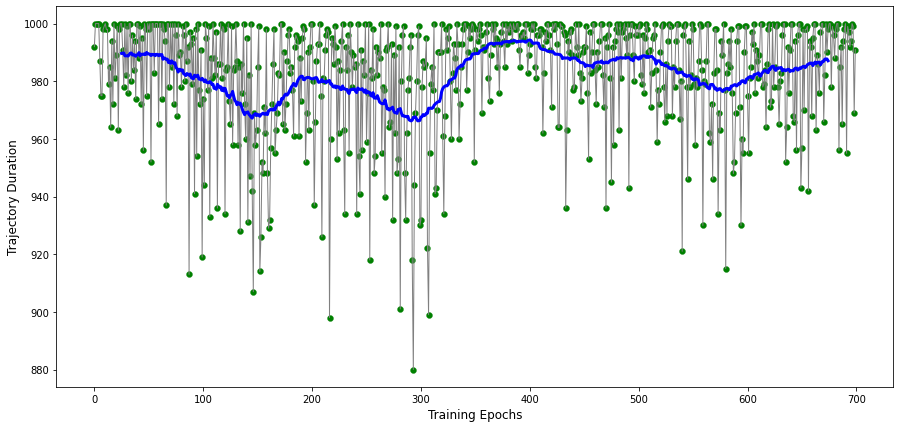

In [ ]:
def running_mean(x):
    N=50
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)

    shift = int(N/2)
    for i in range(shift, conv_len + shift):
        y[i - shift] = kernel @ x[i-shift:i+shift]
        y[i - shift] /= N
    return y

score = np.array(score)
avg_score = running_mean(score)

plt.figure(figsize=(15,7))
plt.ylabel("Trajectory Duration",fontsize=12)
plt.xlabel("Training Epochs",fontsize=12)
plt.plot(score, color='gray' , linewidth=1)
plt.plot(np.arange(25, 25 + len(avg_score)), avg_score, color='blue', linewidth=3)
plt.scatter(np.arange(score.shape[0]),score, 
            color='green' , linewidth=0.3)
plt.show()